Attempt 2

Targets: Add regularization add dropout, use smaller model with GAP 
Results:

Parameters: 7,888

Train Acc: 99.24%

Test Acc: 99.28%

Analysis:

Using dropout helped with the overfitting , as we are adding dropout after each layer only a small amount 0.05 was sufficient, 0.1 reduced the test accuracy
GAP layer helped with the slow increase in layer size

Moving final layer after GAP helped with the capacity.
The test accuracy is flickering a bit, moving Max pool after RF = 5 will help

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
if torch.backends.mps.is_available():
    # Apple Silicon GPU
    device = "mps"
    use_cuda = True
elif torch.cuda.is_available():
    # nVidia GPU
    device = "cuda"
    use_cuda = True
else:
    # CPU
    device = "cpu"

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [6]:

from tqdm import tqdm


def train_model(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
def plot(train_losses, test_losses, train_acc, test_acc):
    t = [t_items.item() for t_items in train_losses]
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


In [7]:
from models import Model_2

In [8]:
!pip install torchsummary
from torchsummary import summary

# run summary on cpu first then shift to device
model = Model_2().to("cpu")
summary(model, input_size=(1, 28, 28))


print("Running models on: ", device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 9, 24, 24]             648
              ReLU-6            [-1, 9, 24, 24]               0
       BatchNorm2d-7            [-1, 9, 24, 24]              18
           Dropout-8            [-1, 9, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             810
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
          Dropout-12           [-1, 10, 22, 22]               0
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

EPOCH: 0


Loss=0.11589010804891586 Batch_id=468 Accuracy=91.45: 100%|██████████| 469/469 [00:08<00:00, 53.73it/s] 



Test set: Average loss: 0.0711, Accuracy: 9801/10000 (98.01%)

EPOCH: 1


Loss=0.08949112892150879 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:07<00:00, 60.50it/s] 



Test set: Average loss: 0.0415, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.12017813324928284 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:07<00:00, 60.47it/s] 



Test set: Average loss: 0.0371, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.06249154731631279 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:07<00:00, 59.65it/s] 



Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.022356653586030006 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:07<00:00, 59.92it/s] 



Test set: Average loss: 0.0304, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.0533631332218647 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:08<00:00, 56.30it/s]   



Test set: Average loss: 0.0303, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.006043913308531046 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:08<00:00, 55.35it/s] 



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.02029491774737835 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:08<00:00, 57.94it/s]  



Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.02575160376727581 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:08<00:00, 58.41it/s]  



Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.008223997429013252 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:08<00:00, 58.53it/s] 



Test set: Average loss: 0.0274, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.021500682458281517 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:08<00:00, 58.43it/s] 



Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.05863500013947487 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:08<00:00, 57.61it/s]  



Test set: Average loss: 0.0262, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.03622681275010109 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:08<00:00, 57.66it/s]  



Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.04783669114112854 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:08<00:00, 54.99it/s]  



Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.05815286934375763 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:08<00:00, 57.85it/s]  



Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)



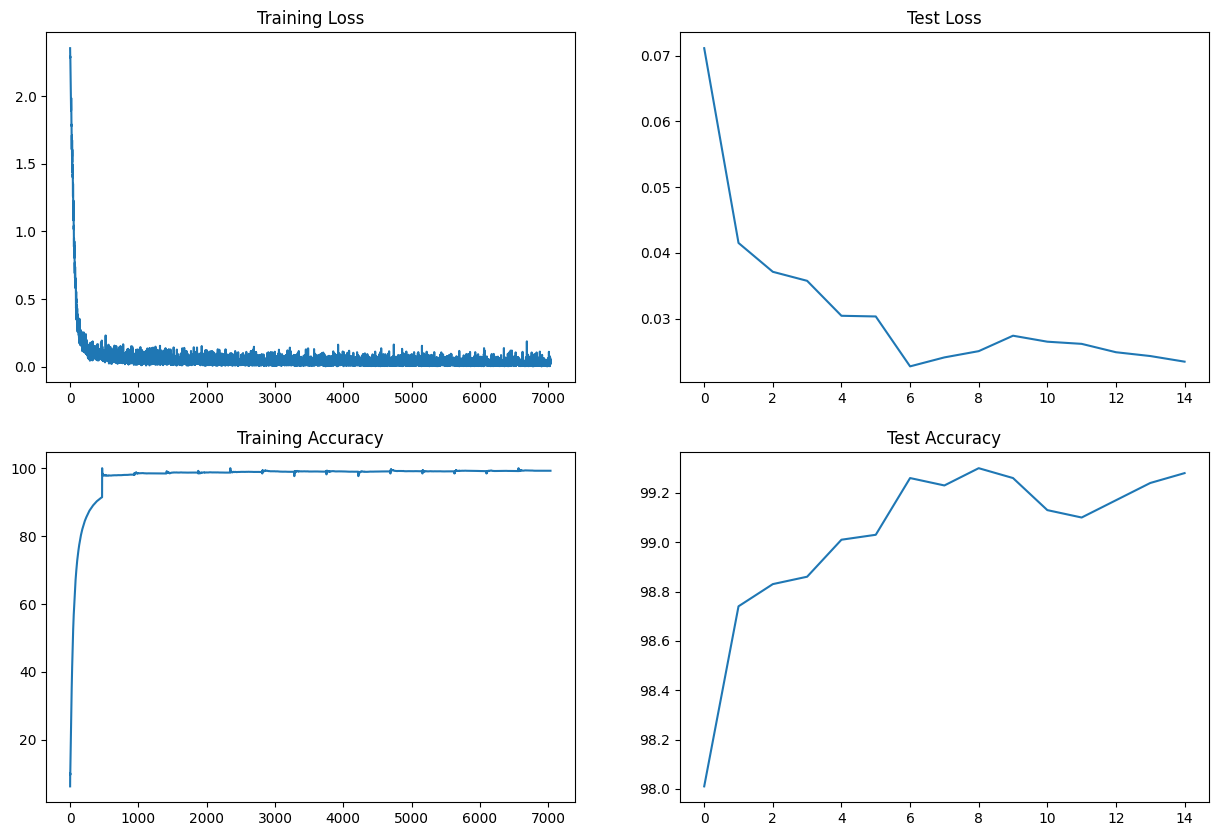

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model =  Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_model(model, device, train_loader, optimizer, epoch)
    test_model(model, device, test_loader)
    # scheduler.step()
    # print("Current LR:", scheduler.get_last_lr())
    

plot(train_losses, test_losses, train_acc, test_acc)